## Workflow to analyze DeepLabCut data

### Imports

In [1]:
# Import Session and Experiment class with helper functions
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables

In [ ]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 4000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.getcwd())

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

In [ ]:
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [ ]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True

### Perform extraction of behavioural information by trial

In [ ]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile)

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

### Match with photometry, videos, and DeepLabCut files

In [ ]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5', verbose=True)

exp_cohort.save()


### Define conditions and groups for extraction

In [5]:
# Defime each trial type as a dictionary of conditions to be met
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 'success': False, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict3 = {'trigger': 'CS_NoGo', 'valid': True, 'success': True, 'button_press': False}
conditions_dict4 = {'trigger': 'CS_NoGo', 'valid': True, 'success': False, 'button_press': False}
# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2, conditions_dict3, conditions_dict4]
# Aliases for conditions
cond_aliases = ['Go hit', 'Go miss', 'NoGo hit', 'NoGo miss']
# Groups as a list of lists
# groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
groups = None

# Window to exctract (in ms)
trial_window = [-2000, 6000]





Another example, for Go-NoGo optogenetic protocol

In [117]:
conditions_dict0 = {'trigger': 'CS_Go', 'valid': True, 's_go_sham': True}
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 's_go_cs_onset': True}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 's_go_bar_off': True}
conditions_dict3 = {'trigger': 'CS_Go', 'valid': True, 's_go_spout': True}
conditions_dict4 = {'trigger': 'CS_Go', 'valid': True, 's_go_error_sham': True}
conditions_dict5 = {'trigger': 'CS_Go', 'valid': True, 's_go_error_bar_off': True}
conditions_dict6 = {'trigger': 'CS_NoGo', 'valid': True, 's_nogo_sham': True}
conditions_dict7 = {'trigger': 'CS_NoGo', 'valid': True, 's_nogo_cs_onset': True}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3, \
    conditions_dict4, conditions_dict5, conditions_dict6, conditions_dict7]
# Aliases for conditions
cond_aliases = ['Go sham', 'Go onset', 'Go bar release', \
    'Go spout', 'Go error sham', 'Go error bar_off', 'NoGo sham', 'NoGo onset']
# Groups as a list of lists
groups = [[280, 282, 283, 294, 295, 299, 300, 301, 302, 303, 304, 305],\
    [284, 285, 296, 297, 306, 307],[289,290,291,292,293]]

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

Example in progress for Cued-Uncued

In [ ]:
# List of uncued conditions as listed on the tasks .csv file for task reaching_go_spout_cued_uncued:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'trigger': 'cued', 'valid': True, 'reward spout cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict1 = {'trigger': 'cued', 'valid': True, 'reward bar cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict2 = {'trigger': 'cued', 'valid': True, 'success': False}
conditions_dict3 = {'trigger': 'uncued', 'valid': True, 'success': False}
conditions_dict4 = {'trigger': 'uncued', 'valid': True, 'reward spout uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict5 = {'trigger': 'uncued', 'valid': True, 'reward bar cued': True, 'free_reward_timer': False, 'success': True}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3, \
    conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Cued spout hit', 'Cued bar hit', 'Cued miss', \
    'Uncued miss', 'Uncued spout hit', 'Uncued bar hit']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

### Set DeepLabCut bodyparts to compute paws centroids

In [158]:
# Name of the labelled body parts from both upper limbs
# The bodyparts from which we draw here are user-defined
# when creating a new DeepLabCut project (config.yaml)

L_paw_parts  = ['MCP II', 'MCP III', 'MCP IV', 'MCP V', 'IP II', 'IP III', \
    'IP IV', 'IP V', 'tip II', 'tip III', 'tip IV', 'tip V'] 

R_paw_parts = ['r MCP II', 'r MCP III', 'r MCP IV', 'r MCP V', 'r IP II', \
    'r IP III', 'r IP IV', 'r IP V', 'r tip II', 'r tip III', 'r tip IV', 'r tip V']

names_of_ave_regions = ['Left_paw','Right_paw']

### Extract DeepLabCut trials and create a Continuous_Dataset

In [ ]:
cont_dataset = exp_cohort.get_deeplabcut_groups(
        groups = None,
        conditions_list = condition_list,
        cond_aliases = cond_aliases,
        when='all', 
        task_names = ['reaching_go_nogo'],
        bodyparts_to_ave = [L_paw_parts, R_paw_parts],
        names_of_ave_regions = ['Left_paw','Right_paw'], 
        bodyparts_to_store = ['spout', 'jaw', 'ear', 'tongue', 'tip III',  'IP III', 'MCP III'],
        normalize_between = ['Left_paw', 'spout'],
        bins_nb = 100,
        three_dims = False, 
        p_thresh = 0.9,
        camera_fps = 100, # not yet functional
        camera_keyword = 'Side', 
        trig_on_ev = None, 
        verbose = True)


### Save DLC Dataset

In [ ]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs'

cont_dataset.save(folder_path, 'DLC_dataset_gonogo')

### Reload a pre-existing dataset

In [110]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\DLC_dataset_opto_continuous_full.pkl'
cont_dataset = load_dataset(dataset_full_path)

Metadata preview

In [ ]:
cont_dataset.metadata_df.head()

### Optional methods

- Implementation of these optional filtering options is first understood as removing subjects, groups, conditions...
- It is a non-permanent way of discarding elements for analysis
- It is based on a "keep" column in the metadata that is True by default and set to False with the filtering function.
- At anytime, <trial_dataset>.filter_reset() can be called to re-include all the elements in the analysis (set all "keep" to True)
- Comment or uncomment lines and fill the lists according to your needs

In [ ]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([0, 1])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (for each condition separately)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have trials
# in all the conditions, if called after filter_min(),
# will discard any subject who do not have the minimum number
# of trials in all the conditions

# cont_dataset.filter_if_not_in_all_cond()


### Plot DeepLabCut position by conditions

 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


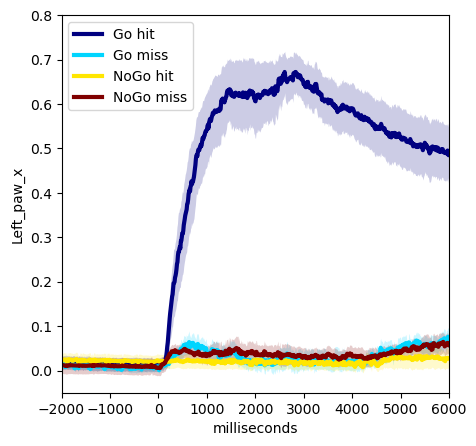

True     2800
False     628
Name: keep, dtype: int64

In [378]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')
cont_dataset.set_conditions(condition_list, cond_aliases)
cont_dataset.lineplot(
    vars = ['Left_paw_x'],
    time_lim = [-2000, 6000],
    time_unit = 'milliseconds',
    error = True,
    ylim = [[-0.05, 0.8]], #[[-0.1, 1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5,5),
    dpi = 100,
    verbose = False)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()


Example line to count how many trials are included for subject 307

In [276]:
cont_dataset.metadata_df.keep[cont_dataset.metadata_df.subject_ID == 307].value_counts()

True     308
False    233
Name: keep, dtype: int64